## Comparing Prediction Models: Predict Click Through Rate (CTR) 

#### Introduction: Packages and Data

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance


In [2]:
#import data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
#inspect data
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CTR            4240 non-null   float64
 1   titleWords     4240 non-null   int64  
 2   adWords        4240 non-null   int64  
 3   depth          4240 non-null   int64  
 4   position       4240 non-null   int64  
 5   advCTR         4240 non-null   float64
 6   advCTRInPos    4240 non-null   float64
 7   queryCTR       4240 non-null   float64
 8   queryCTRInPos  4240 non-null   float64
 9   gender         4240 non-null   object 
 10  age            4240 non-null   object 
dtypes: float64(5), int64(4), object(2)
memory usage: 364.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CTR            1817 non-null   float64
 1   titleWor

In [4]:
df_train.head()

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,male,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,male,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,male,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,female,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,female,19-24


In [5]:
y_train = df_train.pop("CTR")
y_test = df_test.pop("CTR")

In [6]:
print(y_train.describe())
print(y_test.describe())

count    4240.000000
mean        0.054228
std         0.076921
min         0.000000
25%         0.009000
50%         0.028600
75%         0.066700
max         0.634300
Name: CTR, dtype: float64
count    1817.000000
mean        0.053197
std         0.076161
min         0.000000
25%         0.008800
50%         0.027800
75%         0.065500
max         0.614800
Name: CTR, dtype: float64


#### Helper Functions

We need these functions to evaluate the performance of each model. We will use three performance evaluation metrics here: Out-of-Sample R2 (OSR2), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE). The first one needs a helper function. The other two come ready in sklearn.metrics.

In [7]:
#create a function to calculate OSR2

def OSR2 (y_true, y_pred, training_mean):
    baseline_error= np.sum(np.square((training_mean - y_true)))
    model_error = np.sum(np.square((y_pred - y_true)))
    return 1.0- model_error/baseline_error

In [8]:
#createa function to provide the three performance metrics at once for each model

def calc_metrics():
    print(f'OSR2: {OSR2(y_test, y_pred, y_train.mean()):.3f}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')

#### Model 1: Linear Regression

In [9]:
#deal with categorical variables
train = df_train.copy()
test = df_test.copy()
train = pd.get_dummies(train, columns = ['gender', 'age'], drop_first = True)
test = pd.get_dummies(test, columns = ['gender', 'age'], drop_first = True)

In [10]:
model1 = LinearRegression()
model1.fit(train, y_train)
y_pred = model1.predict(test)
calc_metrics()


OSR2: 0.375
MAE: 0.036
RMSE: 0.060


In [11]:

print(pd.DataFrame({"Variable Name": train.columns, "Coefficient": model1.coef_}))
print("Intercept:", model1.intercept_)

     Variable Name  Coefficient
0       titleWords    -0.000522
1          adWords     0.000384
2            depth     0.001969
3         position    -0.006381
4           advCTR     0.448779
5      advCTRInPos     0.557652
6         queryCTR     0.008432
7    queryCTRInPos     0.459923
8      gender_male    -0.005900
9   gender_unknown    -0.044796
10       age_13-18    -0.000537
11       age_19-24    -0.004222
12       age_25-30    -0.005811
13       age_31-40    -0.005837
14         age_41+     0.002304
15     age_unknown     0.028549
Intercept: 0.00352525249687978


#### Model 2: CART for Regression

In [11]:
#deal with categorical variables
train = df_train.copy()
test = df_test.copy()
train = pd.get_dummies(train, columns = ["gender", "age"], drop_first = True)
test = pd.get_dummies(test, columns = ["gender", "age"], drop_first = True)

In [12]:
#build model with default parameters
tree = DecisionTreeRegressor(random_state = 42).fit(train, y_train)
y_pred = tree.predict(test)
calc_metrics()


OSR2: 0.084
MAE: 0.041
RMSE: 0.073


Since the metrics above are really bad for a full trained tree, we should use cost complexity pruning to find a better performing tree

In [13]:
#lets build the model again
tree = DecisionTreeRegressor(random_state = 42)
path = tree.cost_complexity_pruning_path(train, y_train)
alphas = path.ccp_alphas
len(alphas)

3257

In [14]:
alphas = alphas[::10]

In [15]:
len(alphas)

326

In [16]:
osr2_all = []
for alpha in alphas: 
    tree = DecisionTreeRegressor(ccp_alpha = alpha, random_state = 42).fit(train, y_train)
    y_pred = tree.predict(test)
    osr2 = OSR2(y_test,y_pred, y_train.mean())
    osr2_all.append(osr2)

In [17]:
#let's find out the best OSR2
np.max(osr2_all)

np.float64(0.3763392959755538)

In [18]:
#extract the tree with the highest OSR2 so that we can calculate all the metrics
opt_alpha = alphas[np.argmax(osr2_all)]

In [19]:
tree = DecisionTreeRegressor(ccp_alpha= opt_alpha, random_state = 42).fit(train,y_train)
y_pred = tree.predict(test)
calc_metrics()

OSR2: 0.376
MAE: 0.035
RMSE: 0.060


In [ ]:
#lets explore and visualize this tree

In [20]:
tree.tree_.max_depth, tree.tree_.node_count

(7, 39)

In [21]:
#lets build a helper function to visualize this tree
def viz_tree(tree, X, font= 12, figsize = (16,10)):
    plt.figure(figsize=figsize)
    _=plot_tree(tree, feature_names = X.columns, filled = True, fontsize = font)

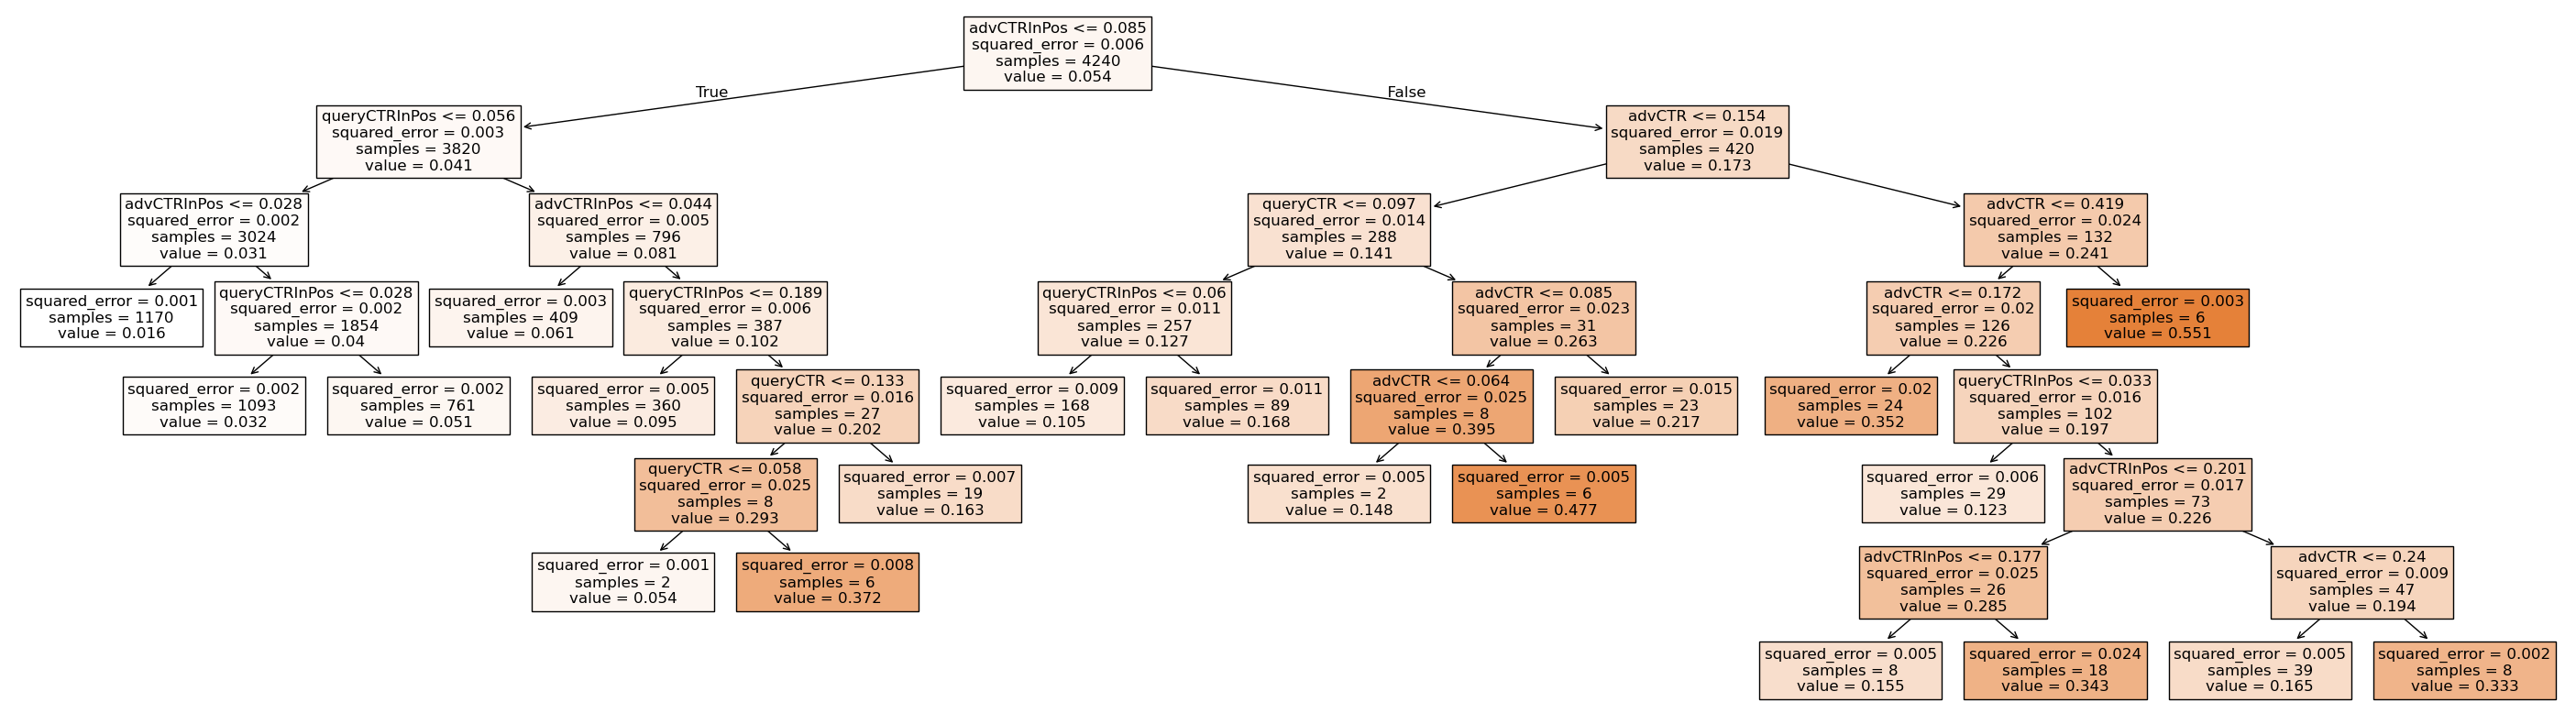

In [22]:
viz_tree(tree, train, figsize = (36,10))

#### Model 3: Random Forest

First we will train the model with the default settings.

In [23]:
rf = RandomForestRegressor(random_state = 42).fit(train, y_train)
y_pred = rf.predict(test)
calc_metrics()

OSR2: 0.468
MAE: 0.032
RMSE: 0.056


It is an imporvement from the CART Model above but it can be better if we boost it. 

#### Model 4: XGBoost

In [24]:
model = XGBRegressor(random_state = 42)
model.fit(train, y_train)
y_pred = model.predict(test)
calc_metrics()

OSR2: 0.470
MAE: 0.032
RMSE: 0.055


#### Hyperparameter Optimization 

##### Grid Search

We will have three hyperparameters that will change simultaneously: 

* number of trees- n_estimator: 10, 50, 100
* maximum depth of the tree- max_depth: 1, 2, 3, 4, 5
* learning rate/shrinkage parameter learning_rate: 0.001, 0.01, 0.1, 0.3

This will create 60 hyperparameter combinations. For each combination, we will do a 5-fold cross-validation (CV), which means that the XGBoost model will be trained 300 times.


In [49]:
import sklearn
print(sklearn.__version__)
from sklearn.model_selection import GridSearchCV

1.6.1


In [25]:
#let's create the parameter grid to use in combinations
param_grid = {'n_estimators': [10,50,80],
              'max_depth': [1,2,3,4,5],
              'learning_rate': [0.001, 0.01, 0.1, 0.3]}

In [29]:
#create model
model = XGBRegressor(random_state=42)

In [30]:
#add parameteres
gcv = GridSearchCV(estimator = model, 
                  param_grid=param_grid,
                  cv=5,
                  scoring='neg_mean_squared_error')

In [31]:
gcv.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 80]},
             scoring='neg_mean_squared_error')

In [32]:
#find the best estimators
gcv.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 80}

In [35]:
#calculate the metrics for the best estimator
y_pred = gcv.best_estimator_.predict(test)
calc_metrics()

OSR2: 0.477
MAE: 0.032
RMSE: 0.055


##### Random Search

In [37]:
#build the model
model = XGBRegressor(random_state = 42)

In [39]:
param_grid = {"n_estimators": range(10,1010,10),
             "max_depth": range(1,21),
             "learning_rate": np.linspace(0.001, 1.0, 50)}
'''
This means that there are a total of 100* 20 * 50 = 100,000 combinations. I will try only 10 of them using RandomSearch
'''

'\nThis means that there are a total of 100* 20 * 50 = 100,000 combinations. I will try only 10 of them using RandomSearch\n'

In [44]:
rcv = RandomizedSearchCV(model, param_distributions = param_grid, cv = 5, n_iter = 10, scoring = 'neg_mean_absolute_error', random_state = 42)

In [45]:
rcv.fit(train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       0.51069388, 0.53108163, 0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
                                        'max_depth': range(1, 21),
                                        'n_estimators': range(10, 1010, 10)},
                   random_state=42, scoring='neg_mean_absolute_error')

In [46]:
rcv.best_params_

{'n_estimators': 660,
 'max_depth': 3,
 'learning_rate': np.float64(0.062163265306122456)}

In [49]:
y_pred = rcv.best_estimator_.predict(test)
calc_metrics()

OSR2: 0.487
MAE: 0.032
RMSE: 0.055


In [50]:
#to see all estimators for this model
pd.DataFrame(rcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.789881,0.029716,0.019931,0.002986,960,18,0.143714,"{'n_estimators': 960, 'max_depth': 18, 'learni...",-0.039386,-0.035490,-0.033029,-0.033186,-0.032114,-0.034641,0.002621,3
1,3.318676,0.067844,0.028103,0.009817,610,9,0.001000,"{'n_estimators': 610, 'max_depth': 9, 'learnin...",-0.041573,-0.038725,-0.039868,-0.037229,-0.038943,-0.039268,0.001430,9
2,0.315373,0.029865,0.013556,0.001561,210,9,0.775735,"{'n_estimators': 210, 'max_depth': 9, 'learnin...",-0.043966,-0.039133,-0.036412,-0.036628,-0.036155,-0.038459,0.002954,6
3,0.810625,0.061584,0.016900,0.002631,870,9,0.551469,"{'n_estimators': 870, 'max_depth': 9, 'learnin...",-0.040948,-0.035885,-0.035108,-0.035467,-0.033188,-0.036119,0.002585,5
4,0.798878,0.118537,0.016325,0.002293,660,3,0.062163,"{'n_estimators': 660, 'max_depth': 3, 'learnin...",-0.036195,-0.032091,-0.033023,-0.031239,-0.031960,-0.032901,0.001742,1
5,0.976943,0.040276,0.017497,0.001522,870,4,0.836898,"{'n_estimators': 870, 'max_depth': 4, 'learnin...",-0.047052,-0.040155,-0.041678,-0.038556,-0.038666,-0.041221,0.003130,10
6,0.897118,0.089903,0.017125,0.001972,950,12,0.367980,"{'n_estimators': 950, 'max_depth': 12, 'learni...",-0.039725,-0.034989,-0.032705,-0.034204,-0.032029,-0.034730,0.002709,4
7,0.852455,0.101996,0.017599,0.001268,990,15,0.877673,"{'n_estimators': 990, 'max_depth': 15, 'learni...",-0.043526,-0.039969,-0.036714,-0.036881,-0.036022,-0.038622,0.002803,7
8,0.342193,0.012804,0.016130,0.000923,320,2,0.449531,"{'n_estimators': 320, 'max_depth': 2, 'learnin...",-0.037140,-0.032431,-0.033589,-0.031999,-0.033180,-0.033668,0.001823,2
9,0.894921,0.085881,0.017666,0.002065,640,3,0.612633,"{'n_estimators': 640, 'max_depth': 3, 'learnin...",-0.042898,-0.039240,-0.038526,-0.035040,-0.037437,-0.038628,0.002566,8


<Axes: title={'center': 'Feature importance'}, ylabel='Features'>

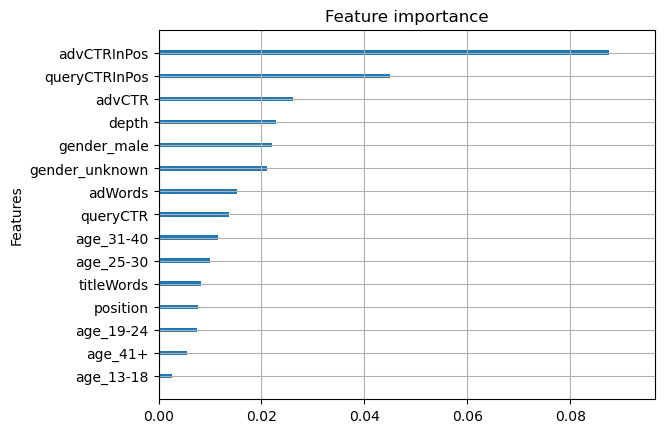

In [52]:
#plot model results
plot_importance(rcv.best_estimator_, importance_type = "gain", show_values= False, xlabel= '')

The XGBRegressor with RandomSearch hyperparameters does better than all other models used here. 

### The END!